# Imports, Functions

In [1]:
from glob import glob
import gpxpy
import gpxpy.gpx

import datetime

import plotly.express as px

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from math import radians, sin, cos, sqrt, atan2

import gspread

# Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 3963.19  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

In [2]:
# define function to transform 'date' column
def transform_date(date_str):
    date_str = date_str.lstrip('0').replace('/', '')
    return date_str

# define function to transform time columns
def transform_time(time_str):
    h,m,s = time_str.split(':')
    t = float(s)/60 + float(m) + float(h)*60
    return t

In [3]:
def load_sheets():
    # read in the raw data from the sheet
    gc = gspread.service_account(filename='./runningbot-380822-f74dc648f73a.json')
    sh = gc.open("running log").sheet1
    
    # get the date, distance, time, and pace columns
    times_frame = pd.DataFrame(sh.get('B2:E999'))
    
    
    # make the first row the header information
    new_header = times_frame.iloc[0] #grab the first row for the header
    times_frame = times_frame[1:] #take the data less the header row
    times_frame.columns = new_header #set the header row as the df header
    
    # get rid of columns with 'None' observations
    times_frame = times_frame.dropna()
    
    # drop rest days from my dataframe
    times_frame = times_frame[~times_frame['distance (miles)'].str.contains("-", na=False)]
    
    # apply transformation to 'date' column
    times_frame['date'] = times_frame['date'].apply(lambda x: transform_date(x))
    times_frame['pace (mins/mile)'] = times_frame['pace (mins/mile)'].apply(lambda x: transform_time(x))
    times_frame['time (minutes)'] = times_frame['time (minutes)'].apply(lambda x: transform_time(x))
    
    # apply transformations to the time columns:
    
    
    return times_frame

In [4]:
times_frame = load_sheets()

# Create Data

In [10]:
plot=False
dfs = []

if plot:
    plt.figure(figsize=(14, 8),dpi=150)
    plt.title('Route latitude and longitude points', size=20);


files = np.sort(glob('*.gpx'))
for file in files:
    
    # open gps file
    with open(file, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        
        
    # get route info
    route_info = []
    for track in gpx.tracks:
        name = track.name
        # get the time and pace from the times_frame
        total_time = times_frame[times_frame['date'] == name]['time (minutes)'].values[0]
        pace = times_frame[times_frame['date'] == name]['pace (mins/mile)'].values[0]
        for segment in track.segments:
            for point in segment.points:
                route_info.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'name':name,
                    'time':total_time,
                    'pace':pace
                })
                
    # convert to a dataframe
    route_df = pd.DataFrame(route_info)
    
    # add total distance run to dataframe
    # Add a new column to the DataFrame to hold the distance traveled
    route_df['distance'] = 0
    
    # Loop through the rows of the DataFrame and calculate the distance traveled between consecutive points
    distance = 0
    for i in range(1, len(route_df)):
        lat1, lon1 = route_df.loc[i-1, 'latitude'], route_df.loc[i-1, 'longitude']
        lat2, lon2 = route_df.loc[i, 'latitude'], route_df.loc[i, 'longitude']
        distance += haversine(lat1, lon1, lat2, lon2)
        route_df.loc[i, 'distance'] = distance

    dfs.append(route_df)
    
    
    # add to plot
    if plot:
        plt.plot(route_df['longitude'], route_df['latitude'])
    
if plot:
    plt.savefig('raw.png',dpi=150)

# A bit more cleaning before plots...

In [11]:
N = len(dfs)
colors = matplotlib.cm.get_cmap('Spectral')(np.linspace(0,1,N))
colors = [matplotlib.colors.to_hex(color,keep_alpha=False) for color in colors]

In [13]:
import matplotlib.dates as mdates

days = []
times = []
paces = []
dist = []

for df in dfs:
    # get relevant data
    days.append(df['name'][0][:-4] + '/' + df['name'][0][-4:-2] + '/' + df['name'][0][-2:])
    dist.append(df['distance'].values[-1])
    times.append(df['time'][0])
    paces.append(df['pace'][0])

# convert dates to datetime objects
# also specify format we want for x-axis
dates = [datetime.datetime.strptime(date, "%m/%d/%y") for date in days]
myFmt = mdates.DateFormatter('%m/%d/%y')


# Plotting!

In [26]:
import plotly.express as px
import pandas as pd

fig = px.line_mapbox(dfs[0], 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name='name',
                        zoom=13, 
                        height=500,
                        width=800,)

for i, df in enumerate(dfs[1:]):
    fig.add_trace(px.line_mapbox(df, 
                                 lat="latitude", 
                                 lon="longitude",
                                 hover_name='name',).data[0])
    
for i in range(len(dfs)):
    fig.data[i].line.color = colors[i]

fig.update_traces(line=dict(width=5.0,))

fig.update_layout(mapbox_style="stamen-toner",
                  mapbox_center_lon=-122.276,
                  mapbox_center_lat=37.87754)

fig.update_layout(showlegend=True)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
fig.write_image("routes.png",scale=2)

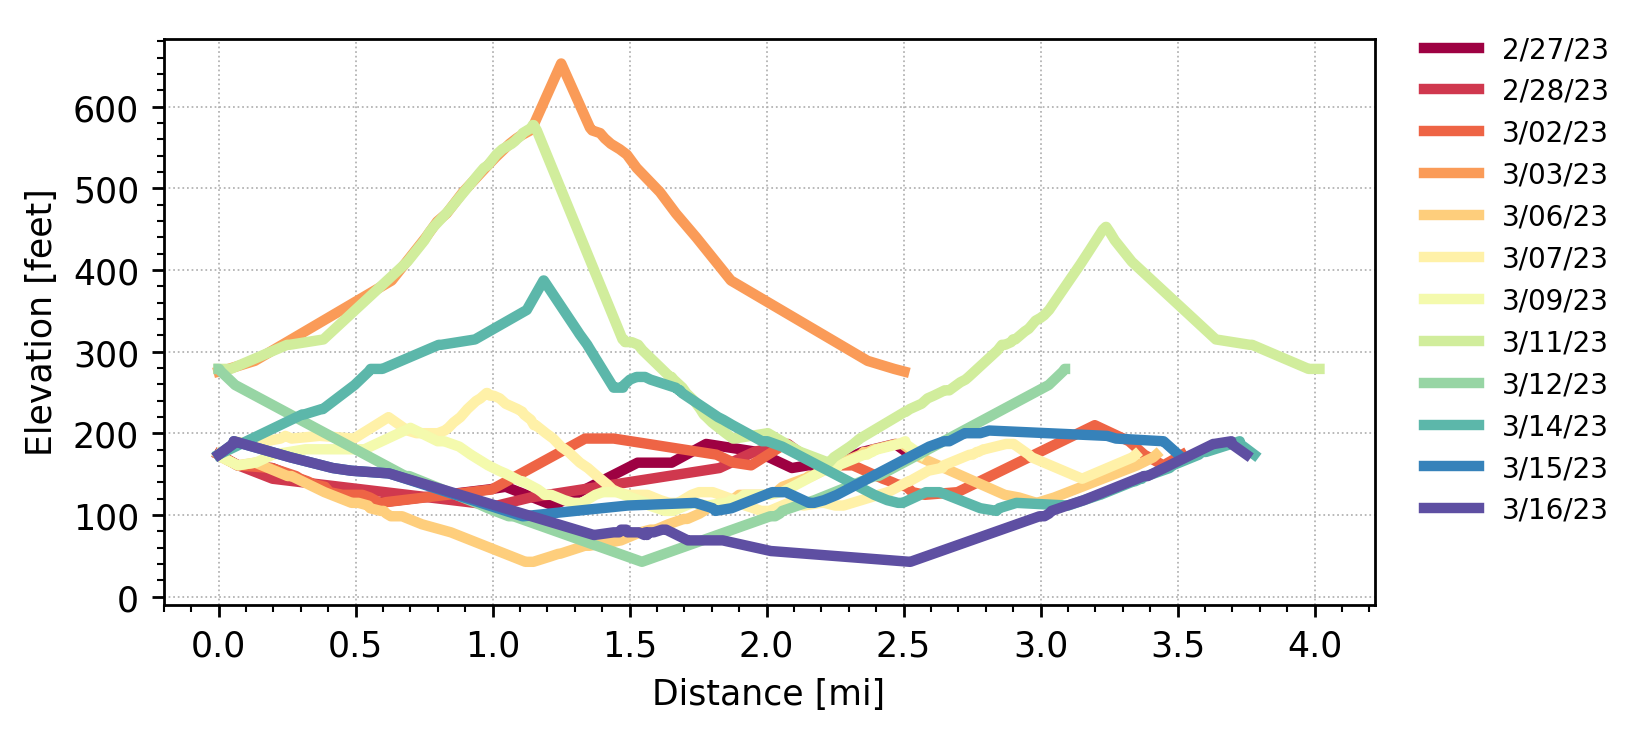

In [15]:
plt.figure(figsize=(6.25,3),dpi=250)

for i, df in enumerate(dfs):
    
    lab = df['name'][0][0:-4] + '/' + \
          df['name'][0][-4:-2] + '/' + \
          df['name'][0][-2:]
    
    plt.plot(df['distance'],
             df['elevation']*3.28084,
             lw=3,
             label=lab,
             c=colors[i])
    
plt.legend(frameon=False,bbox_to_anchor=(1.02, 1.05),fontsize=8)
plt.minorticks_on()
plt.grid(lw=0.5,ls='dotted')
plt.xlabel('Distance [mi]')
plt.ylabel('Elevation [feet]')
plt.ylim(-10,None)
plt.savefig('elevs.png',dpi=250,bbox_inches='tight')

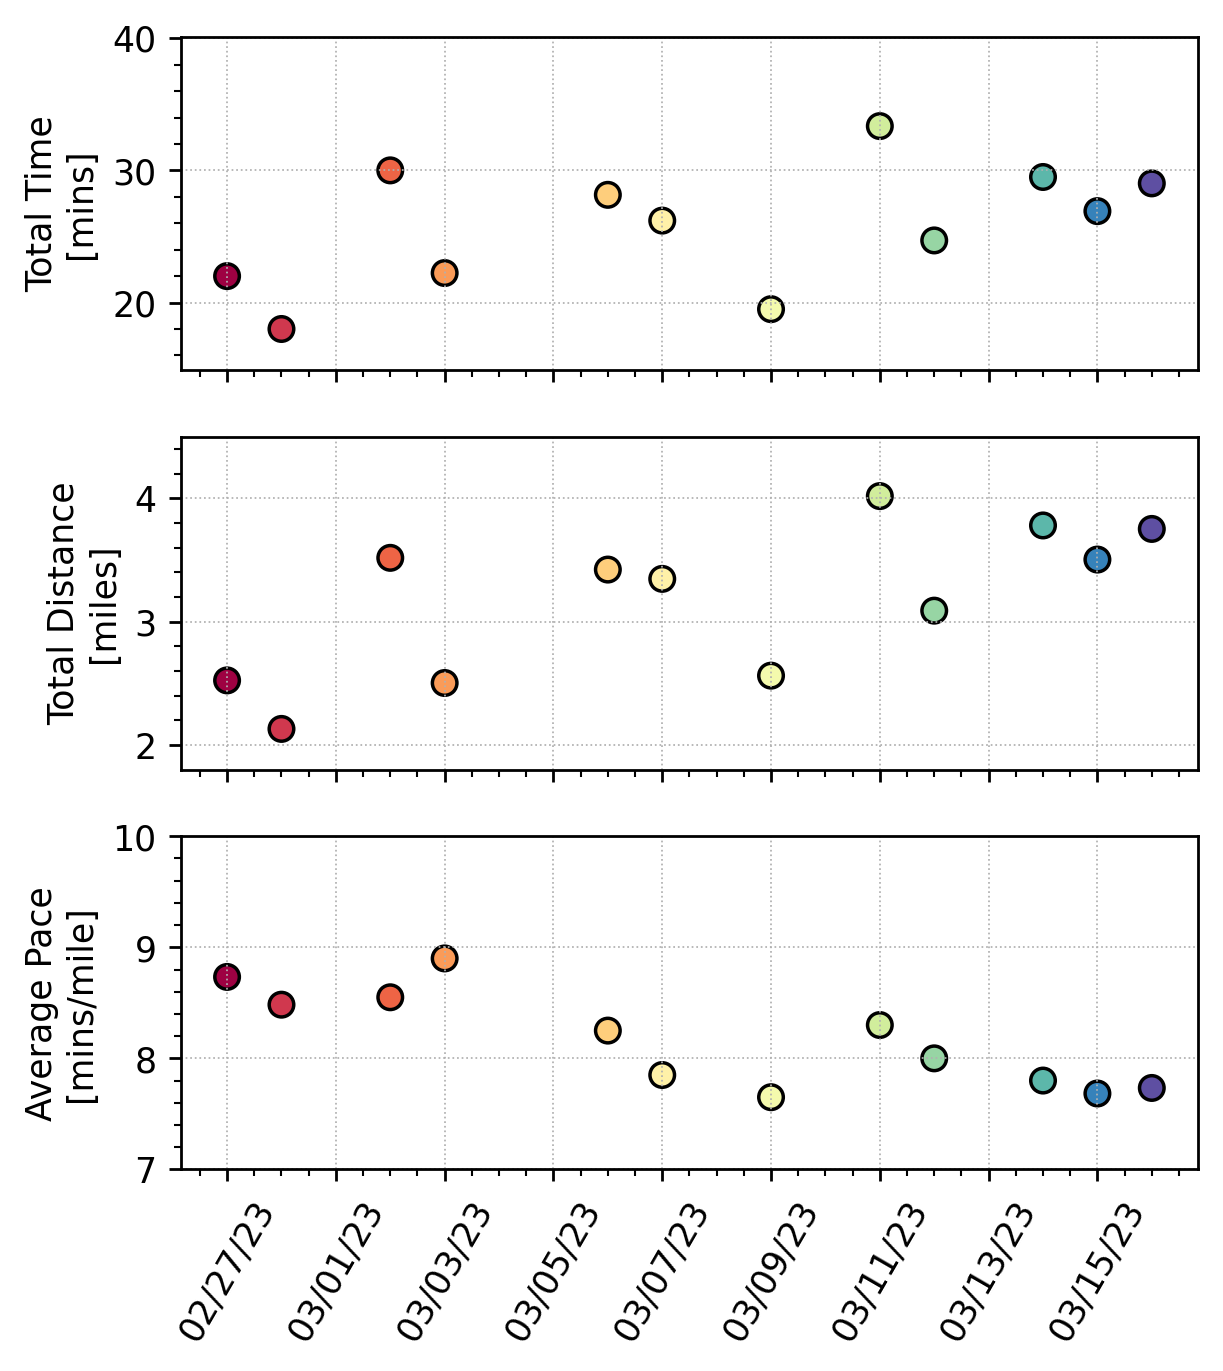

In [16]:
fig, axes = plt.subplots(nrows=3,ncols=1,
                         figsize=(5.25,6),dpi=250,sharex=True)


## AXES 0
# create plot
axes[0].scatter(dates, times, c=colors,
            edgecolors='k',s=50)
axes[0].set_ylabel('Total Time\n[mins]')

# aesthetics
axes[0].minorticks_on()
axes[0].grid(lw=0.5,ls='dotted')
axes[0].xaxis.set_major_formatter(myFmt)

# limits
axes[0].set_ylim(14.9,40.1)

## AXES 1
axes[1].scatter(dates, dist, c=colors,
            edgecolors='k',s=50)
axes[1].set_ylabel('Total Distance\n[miles]')

# aesthetics
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=60)
axes[1].minorticks_on()
axes[1].grid(lw=0.5,ls='dotted')
axes[1].xaxis.set_major_formatter(myFmt)

# limits
axes[1].set_ylim(1.8,4.5)


## AXES 2
axes[2].scatter(dates, paces, c=colors,
            edgecolors='k',s=50)
axes[2].set_ylabel('Average Pace\n[mins/mile]')

# aesthetics
axes[2].set_xticklabels(labels=axes[2].get_xticklabels(), rotation=60)
axes[2].minorticks_on()
axes[2].grid(lw=0.5,ls='dotted')
axes[2].xaxis.set_major_formatter(myFmt)

# limits
axes[2].set_ylim(7,10)

# save
plt.savefig('times.png',dpi=250,bbox_inches='tight')

In [24]:
import plotly.graph_objs as go
import pandas as pd

# Read in the running data
data = df

# Create a 3D surface plot
surface = go.Surface(x=data['longitude'],
                     y=data['latitude'],
                     z=data['elevation'])


# Create a Mapbox layout
mapbox = go.layout.Mapbox(center=go.layout.mapbox.Center(lat=data['latitude'].mean(),
                                                          lon=data['longitude'].mean()),
                          zoom=1,
                          style='stamen-terrain')

# Create a layout with the Mapbox property
layout = go.Layout(mapbox=mapbox)

# Combine the surface and layout plots
fig = go.Figure(data=[surface], layout=layout)

# Show the plot
fig.show()